# <center> CFRM521 Machine Learning in Finance
## <center> Lecture 20
### <center> Yoshihiro Shirai


# Self-attention for time series modeling in Pytorch

- In this lecture we are going to see how to implement a self attention network in PyTorch for time series modeling

- We start with introducing Pytorch for simple feedforward neural networks

- We then explain the self-attention mechanism, and apply its applications to time series analysis

- Finally, we will look at an example on how to predict business cycles using self-attention and using GPU to optimize training time

- There is no reference for this lecture, but a nice paper you may consult is [here](https://arxiv.org/pdf/2207.00493)


# 1. Introduction to PyTorch

- We have so far used Keras for implementing neural networks

- Keras and PyTorch are both popular deep learning frameworks, but they cater to different needs:

    - Keras: A high-level API that runs on top of TensorFlow, designed for ease of use and rapid prototyping. It abstracts many complexities, making it beginner-friendly.

    - PyTorch: A lower-level framework that offers more flexibility and control, widely used in research and production. It provides dynamic computation graphs, making debugging and experimentation easier.

- If you prioritize simplicity and quick model development, Keras might be the better choice. If you need more customization and control, PyTorch is often preferred.

- Let's start with importing all the needed library


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

- With PyTorch we need to move away from functional programming and pass to Object Oriented Programming

- This means that we define a class Model, which inherits all the properties and methods of PyTorch nn.Module class

- We then specify additional properties and methods for our Model class

- Specifically, we need two new functions:
    - The function __init__ is automatically called when an instance of the class Model is defined
        - It takes as inputs the dimensions of the neural network we want to define, which, in this case, has two hidden layers and one output layer
        - It then defines three properties of the Model class, which correspond to the three linear operations that need to be performed by the neural network
    - The function forward takes as input the actual input to the neural network
        - It then compute the first linear operation defined by Model.fc1, and applies to it the relu function (not that relu is a method of the torch.nn.functional class)
        - Similarly, it computes the second layer and the final output

In [3]:
class Model(nn.Module):
    ## input layer (4 dimensions) -> hidden layer 1 (128 dimensions) -> hidden layer 2 (64 dimensions) -> output layer (3 classes of iris flower species)
    ## The model is a simple feedforward neural network with two hidden layers.
    ## The first hidden layer has 128 neurons and the second hidden layer has 64 neurons.
    ## The activation function used is ReLU (Rectified Linear Unit).
    ## The output layer has 1 neuron, which is suitable for regression tasks.
    def __init__(self, in_features = 4, h1 = 8, h2 = 4, out_features = 3):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

- Next, let's see am example of how to use the model.

In [4]:
# Pick a manual seed for reproducibility
torch.manual_seed(41)
# Create an instance of the model
model = Model()
# Print the model architecture
print(model)
# Print the model summary
print("Model Summary:")
print("Input Layer: 4 features")
print("Hidden Layer 1: 8 neurons")
print("Hidden Layer 2: 4 neurons")
print("Output Layer: 3 classes (iris flower species)")

Model(
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=4, bias=True)
  (out): Linear(in_features=4, out_features=3, bias=True)
)
Model Summary:
Input Layer: 4 features
Hidden Layer 1: 8 neurons
Hidden Layer 2: 4 neurons
Output Layer: 3 classes (iris flower species)


We can test on the Iris dataset

In [5]:
url = 'https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/0e7a9b0a5d22642a06d3d5b9bcbad9890c8ee534/iris.csv'
my_df = pd.read_csv(url)
my_df['species']= my_df['species'].map({'setosa': 0.0, 'versicolor': 1.0, 'virginica': 2.0})
X = my_df.drop('species', axis=1).values
y = my_df['species'].values
X.shape, y.shape

((150, 4), (150,))

Next, we split the dataset into testing and training, and we convert it into PyTorch tensors.

- A tensor is nothing but a multidimensional array (a vector being a one dimensional array, and a matrix a two dimensional one)

In [6]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape
# In PyTorch, we need to convert the data into PyTorch tensors.
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)
criterion = nn.CrossEntropyLoss() # Loss function for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # Adam optimizer with learning rate of 0.01

In [ ]:
num_epochs = 1000 # Number of epochs for training
losses = [] # List to store the loss values for each epoch
test_losses = []
# Training loop
for epoch in range(num_epochs):
    step_loss = []
    model.train() # Set the model to training mode
    for i, data in enumerate(X_train):
        # backpropagation
        optimizer.zero_grad() # Zero the gradients 
        y_pred = model(data)
        loss = criterion(y_pred, y_train[i])
        loss.backward() # Backward pass 
        optimizer.step() # Update the weights
        step_loss.append(loss)
        # print every 100 epochs
    loss = sum(step_loss) / len(step_loss) # Average loss for the epoch
    losses.append(loss.detach().numpy()) # Store the loss values

    with torch.no_grad(): # No need to compute gradients for the test set
        model.eval()
        step_test_loss = []
        for i, data in enumerate(X_test):
            y_test_pred = model(data) # Forward pass on the test set
            test_loss = criterion(y_test_pred, y_test[i]) # Compute the test loss
            step_test_loss.append(test_loss)
        test_loss = sum(step_test_loss) / len(step_test_loss)
        test_losses.append(test_loss.detach().numpy())

    # print every 100 epochs
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss}, Test Loss: {test_loss}')
    
    

Epoch [100/1000], Loss: 0.0882636308670044, Test Loss: 0.08087201416492462
Epoch [200/1000], Loss: 0.07792714983224869, Test Loss: 0.08142885565757751
Epoch [300/1000], Loss: 0.06777424365282059, Test Loss: 0.09333553165197372
Epoch [400/1000], Loss: 0.07585026323795319, Test Loss: 0.08100929111242294
Epoch [500/1000], Loss: 0.07905153185129166, Test Loss: 0.0844947025179863
Epoch [600/1000], Loss: 0.07258125394582748, Test Loss: 0.09280763566493988
Epoch [700/1000], Loss: 0.07548774778842926, Test Loss: 0.06052615866065025
Epoch [800/1000], Loss: 0.07233843207359314, Test Loss: 0.060417089611291885
Epoch [900/1000], Loss: 0.07313550263643265, Test Loss: 0.05666176974773407
Epoch [1000/1000], Loss: 0.06621654331684113, Test Loss: 0.051681999117136


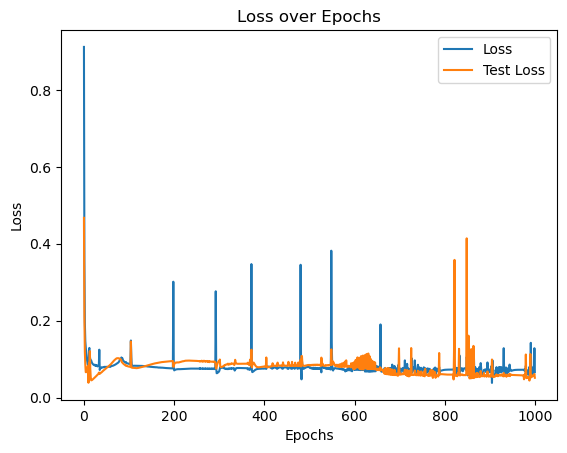

In [ ]:
# Visualizing the loss over epochs
average_loss = np.cumsum(losses) / np.arange(1, len(losses) + 1)
average_test_loss = np.cumsum(test_losses) / np.arange(1, len(test_losses) + 1)

plt.plot(average_loss, label='Loss')
plt.plot(average_test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

In [18]:
class ModelX(nn.Module):
    ## input layer (4 dimensions) -> hidden layer 1 (128 dimensions) -> hidden layer 2 (64 dimensions) -> output layer (3 classes of iris flower species)
    ## The model is a simple feedforward neural network with two hidden layers.
    ## The first hidden layer has 128 neurons and the second hidden layer has 64 neurons.
    ## The activation function used is ReLU (Rectified Linear Unit).
    ## The output layer has 1 neuron, which is suitable for regression tasks.
    def __init__(self, in_features = 4, h1 = 8, h2 = 4, out_features = 3):
        super(ModelX, self).__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_features)
        self._init_weights()
        # Initialize weights using Xavier uniform distribution

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [20]:
# Pick a manual seed for reproducibility
torch.manual_seed(41)
# Create an instance of the model
modelX = ModelX()
optimizer = torch.optim.Adam(modelX.parameters(), lr=0.01)

In [23]:
num_epochs = 10000 # Number of epochs for training
losses = [] # List to store the loss values for each epoch
test_losses = []
# Training loop
for epoch in range(num_epochs):
    step_loss = []
    modelX.train() # Set the model to training mode
    for i, data in enumerate(X_train):
        # backpropagation
        optimizer.zero_grad() # Zero the gradients 
        y_pred = modelX(data)
        loss = criterion(y_pred, y_train[i])
        loss.backward() # Backward pass 
        optimizer.step() # Update the weights
        step_loss.append(loss)
        # print every 100 epochs
    loss = sum(step_loss) / len(step_loss) # Average loss for the epoch
    losses.append(loss.detach().numpy()) # Store the loss values

    # with torch.no_grad(): # No need to compute gradients for the test set
    #     modelX.eval()
    #     step_test_loss = []
    #     for i, data in enumerate(X_test):
    #         y_test_pred = modelX(data) # Forward pass on the test set
    #         test_loss = criterion(y_test_pred, y_test[i]) # Compute the test loss
    #         step_test_loss.append(test_loss)
    #     test_loss = sum(step_test_loss) / len(step_test_loss)
    #     test_losses.append(test_loss.detach().numpy())

    # print every 100 epochs
    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss}, Test Loss: {test_loss}')
    

Epoch [1000/10000], Loss: 0.07833503186702728, Test Loss: 0.06125502660870552
Epoch [2000/10000], Loss: 0.07625076919794083, Test Loss: 0.06125502660870552
Epoch [3000/10000], Loss: 0.0761759802699089, Test Loss: 0.06125502660870552
Epoch [4000/10000], Loss: 0.07600688189268112, Test Loss: 0.06125502660870552
Epoch [5000/10000], Loss: 0.09538383781909943, Test Loss: 0.06125502660870552
Epoch [6000/10000], Loss: 0.0747760608792305, Test Loss: 0.06125502660870552
Epoch [7000/10000], Loss: 0.074263796210289, Test Loss: 0.06125502660870552
Epoch [8000/10000], Loss: 0.07552918046712875, Test Loss: 0.06125502660870552
Epoch [9000/10000], Loss: 0.07437681406736374, Test Loss: 0.06125502660870552
Epoch [10000/10000], Loss: 0.0985177606344223, Test Loss: 0.06125502660870552


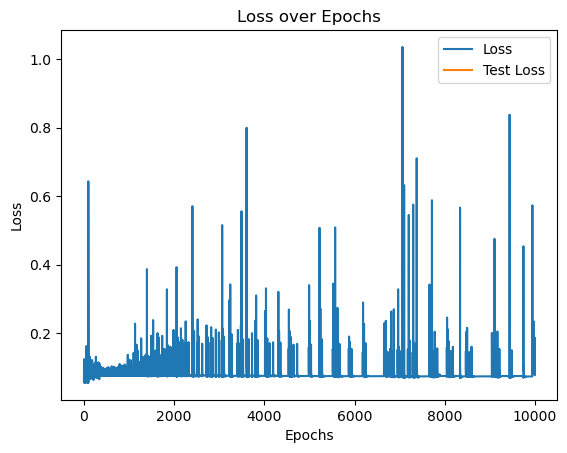

In [27]:
# Visualizing the loss over epochs
average_loss = np.cumsum(losses) / np.arange(1, len(losses) + 1)
average_test_loss = np.cumsum(test_losses) / np.arange(1, len(test_losses) + 1)

plt.plot(losses, label='Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

In [26]:
print(losses)

[array(0.06257789, dtype=float32), array(0.1149015, dtype=float32), array(0.12462638, dtype=float32), array(0.08699681, dtype=float32), array(0.07387521, dtype=float32), array(0.06679859, dtype=float32), array(0.06717157, dtype=float32), array(0.06929263, dtype=float32), array(0.06010481, dtype=float32), array(0.06345949, dtype=float32), array(0.06041067, dtype=float32), array(0.05527915, dtype=float32), array(0.07085849, dtype=float32), array(0.06063219, dtype=float32), array(0.06248521, dtype=float32), array(0.0562565, dtype=float32), array(0.0750159, dtype=float32), array(0.06188608, dtype=float32), array(0.05970918, dtype=float32), array(0.05772378, dtype=float32), array(0.09247847, dtype=float32), array(0.06457901, dtype=float32), array(0.06580091, dtype=float32), array(0.06426761, dtype=float32), array(0.06252784, dtype=float32), array(0.05806616, dtype=float32), array(0.06513994, dtype=float32), array(0.08655794, dtype=float32), array(0.05703394, dtype=float32), array(0.05703512